In [2]:
#we are importing email package for convenience
import os, sys, email,re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud
from email import policy 
from sklearn.feature_extraction.text import TfidfVectorizer

# Network analysis
from email.parser import BytesParser
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
# NLP
import nltk
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from stop_words import get_stop_words
from gensim.utils import simple_preprocess
from nltk.stem.porter import PorterStemmer

from sklearn.decomposition import NMF
from nltk.tokenize import RegexpTokenizer
# To build the dictionary
from collections import defaultdict
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
emails_df=pd.read_csv('Enron_emails_small.csv')
emails_df=emails_df.iloc[:,1:]

print("successfully loaded {} rows and {} columns!".format (emails_df.shape[0], emails_df.shape[1]))

successfully loaded 15522 rows and 2 columns!


In [5]:
#returns a message object structure from a string.
Messages=list(map(email.message_from_string,emails_df['message']))
emails_df.drop('message',axis=1,inplace=True)

In [6]:
keys=Messages[0].keys()
for key in keys:
    emails_df[key]=[doc[key] for doc in Messages]

In [7]:
def get_text_from_email(msg):
    parts=[]
    # each part is a either non-multipart, or another multipart message
    # that contains further parts... Message is organized like a tree
    for part in msg.walk():
        if part.get_content_type() =='text/plain':
            parts.append(part.get_payload())
    return ''.join(parts)

In [8]:
emails_df['content']=list(map(get_text_from_email,Messages))

In [9]:
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del Messages

In [76]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,jones-t/all_documents/634.,<17820178.1075846925335.JavaMail.evans@thyme>,"Tue, 4 Jan 2000 08:20:00 -0800 (PST)",tana.jones@enron.com,alicia.goodrow@enron.com,Re: Dinner,1.0,text/plain; charset=us-ascii,7bit,Tana Jones,Alicia Goodrow,,,\Tanya_Jones_Dec2000\Notes Folders\All documents,JONES-T,tjones.nsf,"It would be nice if you could be at my dinner,...",jones-t
1,mann-k/all_documents/5690.,<29110382.1075845717882.JavaMail.evans@thyme>,"Tue, 15 May 2001 11:03:00 -0700 (PDT)",kay.mann@enron.com,sheila.tweed@enron.com,Re: Override letter,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,Sheila Tweed,,,\Kay_Mann_June2001_1\Notes Folders\All documents,MANN-K,kmann.nsf,Absolutely. \n\n\nFrom: Sheila Tweed@ECT on 0...,mann-k
2,dasovich-j/sent/423.,<6812040.1075843194135.JavaMail.evans@thyme>,"Thu, 28 Sep 2000 08:59:00 -0700 (PDT)",jeff.dasovich@enron.com,christine.piesco@oracle.com,Teams,1.0,text/plain; charset=us-ascii,7bit,Jeff Dasovich,Christine.Piesco@oracle.com,,,\Jeff_Dasovich_Dec2000\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,Christine:\n\nMy apologies. My schedule melte...,dasovich-j
3,kaminski-v/var/63.,<21547648.1075856642126.JavaMail.evans@thyme>,"Mon, 9 Oct 2000 01:23:00 -0700 (PDT)",tanya.tamarchenko@enron.com,vince.kaminski@enron.com,Re: FYI: UK Var issues,1.0,text/plain; charset=us-ascii,7bit,Tanya Tamarchenko,Vince J Kaminski,,,\Vincent_Kaminski_Jun2001_5\Notes Folders\Var,Kaminski-V,vkamins.nsf,"Vince, \nUK VAR breached the limit last week.\...",kaminski-v
4,mann-k/_sent_mail/3208.,<12684200.1075846107179.JavaMail.evans@thyme>,"Fri, 13 Oct 2000 01:50:00 -0700 (PDT)",kay.mann@enron.com,"lisa.bills@enron.com, ben.jacoby@enron.com",Change Order #5--Pleasanton Transformer,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,"Lisa Bills, Ben Jacoby",,,\Kay_Mann_June2001_4\Notes Folders\'sent mail,MANN-K,kmann.nsf,Any problems/comments?\n----------------------...,mann-k


In [10]:
re0 = re.compile('>')
re1 = re.compile('(Message-ID(.*?\n)*X-FileName.*?\n)|''(To:(.*?\n)*?Subject.*?\n)|''(< (Message-ID(.*?\n)*.*?X-FileName.*?\n))')
re2 = re.compile('(.+)@(.+)') # Remove emails
re3 = re.compile('\s(-----)(.*?)(-----)\s', re.DOTALL)
re4 = re.compile('''\s(\*\*\*\*\*)(.*?)(\*\*\*\*\*)\s''', re.DOTALL)
re5 = re.compile('\s(_____)(.*?)(_____)\s', re.DOTALL)
re6 = re.compile('\n( )*-.*')
re7 = re.compile('\n( )*\d.*')
re8 = re.compile('(\n( )*[\w]+($|( )*\n))|(\n( )*(\w)+(\s)+(\w)+(( )*\n)|$)|(\n( )*(\w)+(\s)+(\w)+(\s)+(\w)+(( )*\n)|$)')
re9 = re.compile('.*orwarded.*')
re10 = re.compile('From.*|Sent.*|cc.*|Subject.*|Embedded.*|http.*|\w+\.\w+|.*\d\d/\d\d/\d\d\d\d.*')
re11 = re.compile(' [\d:;,.]+ ')
re12 = re.compile('\b\w{1,3}\b') 

In [11]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject','edu', 'use','com','mailto','ect'])

def clean_text(text):
    #text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(re0, ' ' ,text)
    text = re.sub(re1, ' ', text)
    text = re.sub(re2, ' ', text)
    text = re.sub(re3, ' ', text)
    text = re.sub(re4, ' ', text)
    text = re.sub(re5, ' ', text)
    text = re.sub(re6, ' ', text)
    text = re.sub(re7, ' ', text)
    text = re.sub(re8, ' ', text)
    text = re.sub(re9, ' ', text)
    text = re.sub(re10, ' ', text)
    text = re.sub(re11, ' ', text)
    text = re.sub(re12, ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

emails_df["clean_content"]=emails_df.content.apply(clean_text)
#get rid of consequence duplicates
emails_df["clean_content"]=emails_df.clean_content.str.replace(r'\b(\w+)(\s+\1)+\b',r'\1')

In [12]:
eng_stopwords = stopwords.words('english')
eng_stopwords.extend(['from', 'subject','edu', 'use','com','mailto','ect','thank','call'])
print("we use  "+str(len(eng_stopwords)) +"stop-words from nltk library")

def remove_stop_word(text):
    string_split=text.split()
    filtered_word_list=[word for word in string_split if word not in eng_stopwords]
    return ' '.join(filtered_word_list)

we use  188stop-words from nltk library


In [13]:
emails_df["clean_content"]=emails_df["clean_content"].apply(remove_stop_word)

In [16]:
emails_df["clean_content"].head()

0    would nice could dinner, since probably know a...
1    absolutely. good point! peter start draft over...
2    christine: apologies. schedule melted talked m...
3    vince, uk var breached limit last week. uk tra...
4    redraft change order #5 lm contract provide pu...
Name: clean_content, dtype: object

In [14]:
def preprocess(text):
    string_split=text.split()
    adjust_length=[word for word in string_split if len(word)>2]
    return ' '.join(adjust_length)

In [15]:
emails_df["clean_content"]=emails_df["clean_content"].apply(preprocess)

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,min_df=0.1, 
                                 use_idf=True,ngram_range=(1,3))

#fit the TfidfVectorizer to our data
tfidf_matrix = tfidf_vectorizer.fit_transform(emails_df["clean_content"])

print("In total, there are {} reviews and {} terms.". format(str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])))

In total, there are 15522 reviews and 44 terms.


In [132]:
tfidf_vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [18]:
#words slected by tfidf model
tf_selected_words = tfidf_vectorizer.get_feature_names()

In [21]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[-2.22044605e-16,  1.00000000e+00,  6.20414209e-01, ...,
         1.00000000e+00,  1.00000000e+00,  8.76391305e-01],
       [ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 6.20414209e-01,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -2.22044605e-16,  8.02428321e-01,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         8.02428321e-01, -2.22044605e-16,  1.00000000e+00],
       [ 8.76391305e-01,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00, -2.22044605e-16]])

<b> NMF factorization </b>

In [19]:
k=20

nmf=NMF(n_components=20)
nmf.fit(tfidf_matrix)

for i in range(0,k):
    word_list=[]
    print("cluster%d:"%i)
    for j in nmf.components_.argsort()[i,-15:-1]:
        word_list.append(tf_selected_words[j])
    print(word_list)

cluster0:
['date', 'enron', 'know', 'please', 'work', 'business', 'could', 'last', 'take', 'like', 'well', 'day', 'it', 'information']
cluster1:
['questions', 'take', 'could', 'know', 'make', 'last', 'also', 'energy', 'following', 'well', 'work', 'contact', 'help', 'business']
cluster2:
['could', 'date', 'let', 'enron', 'day', 'energy', 'also', 'help', 'take', 'business', 'make', 'following', 'contact', 'questions']
cluster3:
['last', 'make', 'take', 'also', 'well', 'back', 'like', 'work', 'it', 'think', 'questions', 'want', 'let know', 'let']
cluster4:
['gas', 'you', 'help', 'houston', 'information', 'it', 'get', 'back', 'last', 'know', 'questions', 'day', 'following', 'energy']
cluster5:
['gas', 'get', 'houston', 'information', 'it', 'following', 'next', 'back', 'take', 'work', 'also', 'well', 'could', 'help']
cluster6:
['business', 'gas', 'get', 'help', 'houston', 'it', 'know', 'following', 'power', 'let', 'information', 'also', 'questions', 'see']
cluster7:
['next', 'questions', 'm

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


<b> K-means Clustering </b>

In [23]:
tfidf_matrix = tfidf_vectorizer.fit_transform(emails_df["clean_content"]) #fit the vectorizer to email_Content
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)

(15522, 44)


In [30]:
k=7
clf = KMeans(n_clusters=k, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
clf.fit(tfidf_matrix)

KMeans(max_iter=50, n_clusters=7, n_init=1)

In [32]:
clusters = clf.labels_.tolist()
emails_df["cluster"]=clusters
labels = clf.fit_predict(tfidf_matrix)

In [22]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,clean_content,cluster
0,jones-t/all_documents/634.,<17820178.1075846925335.JavaMail.evans@thyme>,"Tue, 4 Jan 2000 08:20:00 -0800 (PST)",tana.jones@enron.com,alicia.goodrow@enron.com,Re: Dinner,1.0,text/plain; charset=us-ascii,7bit,Tana Jones,Alicia Goodrow,,,\Tanya_Jones_Dec2000\Notes Folders\All documents,JONES-T,tjones.nsf,"It would be nice if you could be at my dinner,...",jones-t,"would nice could dinner, since probably know a...",8
1,mann-k/all_documents/5690.,<29110382.1075845717882.JavaMail.evans@thyme>,"Tue, 15 May 2001 11:03:00 -0700 (PDT)",kay.mann@enron.com,sheila.tweed@enron.com,Re: Override letter,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,Sheila Tweed,,,\Kay_Mann_June2001_1\Notes Folders\All documents,MANN-K,kmann.nsf,Absolutely. \n\n\nFrom: Sheila Tweed@ECT on 0...,mann-k,absolutely. good point! peter start draft over...,6
2,dasovich-j/sent/423.,<6812040.1075843194135.JavaMail.evans@thyme>,"Thu, 28 Sep 2000 08:59:00 -0700 (PDT)",jeff.dasovich@enron.com,christine.piesco@oracle.com,Teams,1.0,text/plain; charset=us-ascii,7bit,Jeff Dasovich,Christine.Piesco@oracle.com,,,\Jeff_Dasovich_Dec2000\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,Christine:\n\nMy apologies. My schedule melte...,dasovich-j,christine: apologies. schedule melted talked m...,9
3,kaminski-v/var/63.,<21547648.1075856642126.JavaMail.evans@thyme>,"Mon, 9 Oct 2000 01:23:00 -0700 (PDT)",tanya.tamarchenko@enron.com,vince.kaminski@enron.com,Re: FYI: UK Var issues,1.0,text/plain; charset=us-ascii,7bit,Tanya Tamarchenko,Vince J Kaminski,,,\Vincent_Kaminski_Jun2001_5\Notes Folders\Var,Kaminski-V,vkamins.nsf,"Vince, \nUK VAR breached the limit last week.\...",kaminski-v,"vince, var breached limit last week. traders a...",13
4,mann-k/_sent_mail/3208.,<12684200.1075846107179.JavaMail.evans@thyme>,"Fri, 13 Oct 2000 01:50:00 -0700 (PDT)",kay.mann@enron.com,"lisa.bills@enron.com, ben.jacoby@enron.com",Change Order #5--Pleasanton Transformer,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,"Lisa Bills, Ben Jacoby",,,\Kay_Mann_June2001_4\Notes Folders\'sent mail,MANN-K,kmann.nsf,Any problems/comments?\n----------------------...,mann-k,redraft change order contract provide purchase...,10


In [23]:
print('number of emails included in each cluster')
cluster_size=emails_df['cluster'].value_counts().to_frame()
cluster_size

number of emails included in each cluster


,cluster
1,2722
9,1443
0,1356
5,962
16,952
11,735
6,646
10,644
17,639
15,619


In [24]:
def top_tfidf_features(row, features, top_words = 20):
	# argsort produces the indices that orders the row by tf-idf value
	# reverse them (into descending order) and select the top words
    top_ids = np.argsort(row)[::-1][:top_words]
    top_features = [(features[i], row[i]) for i in top_ids]
    df = pd.DataFrame(top_features, columns=['features', 'score'])
    return df

In [25]:
def top_terms(X, features, grp_ids = None, min_tfidf = 0.1, top_words = 20):
    if grp_ids:
        msgs = X[grp_ids].toarray()
    else:
        msgs = X.toarray()
    msgs[msgs < min_tfidf] = 0
    # calculate the mean of each column across the selected rows (which results in a single row of tf-idf values)
    tfidf_means = np.mean(msgs, axis = 0)
    # then pass on to the previous func for picking out the top n words
    return top_tfidf_features(tfidf_means, features, top_words)

In [26]:
def top_words_per_cluster(X, y, features, min_tfidf = 0.1, top_words = 20):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y == label) 
        features_df = top_terms(X, features, ids, min_tfidf = min_tfidf, top_words = top_words)
        features_df.label = label
        dfs.append(features_df)
    return dfs

In [27]:
def plot_top_words(dfs):
    fig = plt.figure(figsize = (11, 8), facecolor = "w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad = 16, fontsize = 13)
        ax.set_title("cluster = " + str(df.label), fontsize = 15)
        ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (-2, 2))
        ax.barh(x, df.score, align = 'center', color = '#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1] + 1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom = 0.09, right = 0.97, left = 0.15, top = 0.95, wspace = 0.52)
    plt.show()

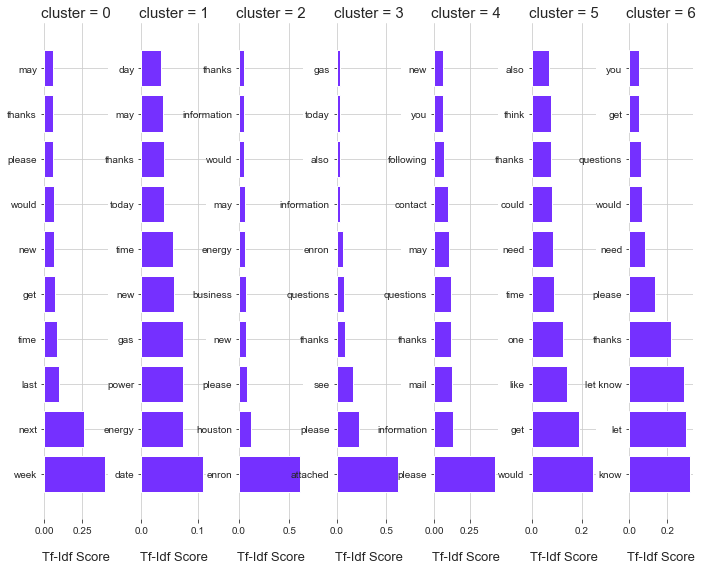

In [33]:
tops = top_words_per_cluster(tfidf_matrix, labels, tf_selected_words, 0.1, 10)
plot_top_words(tops)

In [29]:
def get_top_word(bag_of_words,clusters,bag_of_word_names,n_terms):
    df=pd.DataFrame(bag_of_words.todense()).groupby(clusters).mean()
    
    for index,row in df.iterrows():
        print('\033[1m','\nCluster {}'.format(index),'\033[0m')
        print(','.join([bag_of_word_names[t] for t in np.argsort(row)[:-n_terms:-1]]))
              
get_top_word(tfidf_matrix,labels,tf_selected_words,15)        

 
Cluster 0 
get,new,you,one,today,need,day,want,back,it,think,also,business,take
 
Cluster 1 
contact,please,questions,information,enron,time,may,attached,you,thanks,new,need,help,houston
 
Cluster 2 
gas,please,enron,would,thanks,day,new,attached,may,also,need,get,power,energy
 
Cluster 3 
enron,houston,new,please,business,would,energy,also,information,know,well,may,thanks,one
 
Cluster 4 
know,let,let know,please,thanks,need,would,questions,get,you,attached,enron,want,like
 
Cluster 5 
week,next,last,get,time,would,new,back,one,day,need,you,please,work
 
Cluster 6 
energy,gas,power,enron,new,would,please,also,business,may,thanks,information,time,attached
 
Cluster 7 
date,energy,please,houston,new,enron,thanks,mail,get,attached,day,time,questions,today
 
Cluster 8 
attached,please,questions,thanks,enron,see,you,today,houston,may,information,would,contact,also
 
Cluster 9 
time,please,date,get,thanks,houston,enron,day,one,need,you,take,today,make
 
Cluster 10 
following,please,thanks